In [1]:
from qampy import signals, impairments, equalisation, phaserec, helpers
from qampy.theory import ber_vs_es_over_n0_qam as ber_theory
from qampy.helpers import normalise_and_center as normcenter
from qampy.core.filter import rrcos_pulseshaping as lowpassFilter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams['lines.linewidth'] = 2

In [3]:
# Geração do sinal QAM

M = 64        # ordem da modulação
Fb = 40e9      # taxa de símbolos
SpS = 4         # amostras por símbolo
Fs = SpS*Fb    # taxa de amostragem
SNR = 40        # relação sinal ruído (dB)
rolloff = 0.01  # Rolloff do filtro formatador de pulso

# Gera sequência de símbolos QAM e a filtra com um filtro formatador de pulso rrc (root-raised cosine)
s = signals.ResampledQAM(M, 2**16, fb=Fb, fs=Fs, nmodes=2,
                         resamplekwargs={"beta": rolloff, "renormalise": True})

# Adiciona ruído gaussiano
s = impairments.simulate_transmission(s, snr=SNR)

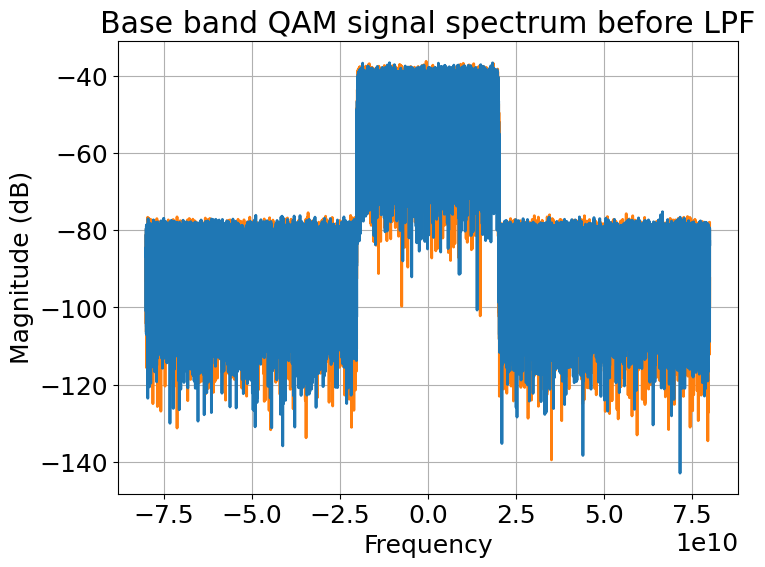

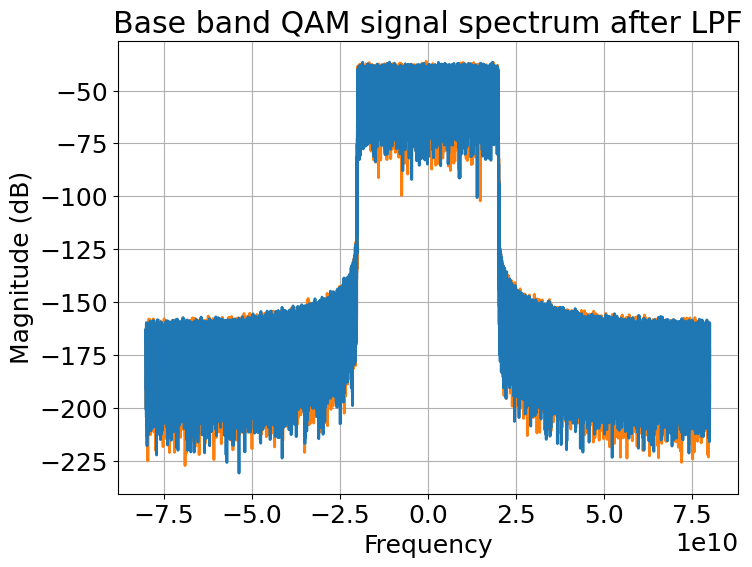

In [4]:
# Plota espectro do sinal QAM em banda base
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(s[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(s[1], Fs=s.fs, scale='dB', color='C0')
plt.title('Base band QAM signal spectrum before LPF')
plt.grid(True)

# Filtra ruído fora da banda do sinal (out-of-band noise)
sfilt = normcenter(lowpassFilter(s, Fs, 1/Fb, 0.001, taps=4001))
fig = plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfilt[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(sfilt[1], Fs=s.fs, scale='dB', color='C0')
plt.title('Base band QAM signal spectrum after LPF')
plt.grid(True)

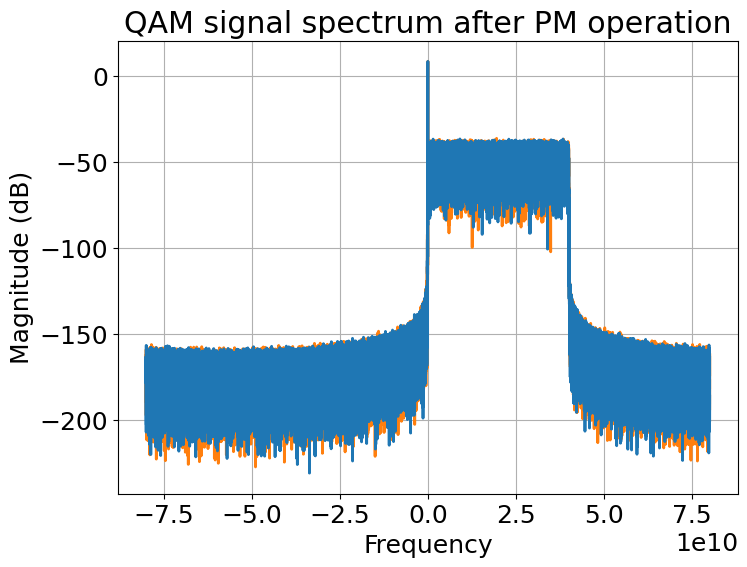

In [5]:
# Gera sinal de fase mínima (sfm(t) = A + s(t)*exp(j*2π*Δf*t))

sfm = sfilt.copy()

t = np.arange(0, s[0].size)*1/s.fs

A = (np.max(np.abs(sfilt)))*np.exp(1j*np.deg2rad(45))
Δf = 2*np.pi*(sfilt.fb/2)*t
sfm = A + sfilt*np.exp(1j*Δf)

plt.figure(figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
plt.magnitude_spectrum(sfm[0], Fs=s.fs, scale='dB', color='C1')
plt.magnitude_spectrum(sfm[1], Fs=s.fs, scale='dB', color='C0')
plt.title('QAM signal spectrum after PM operation')
plt.grid(True)

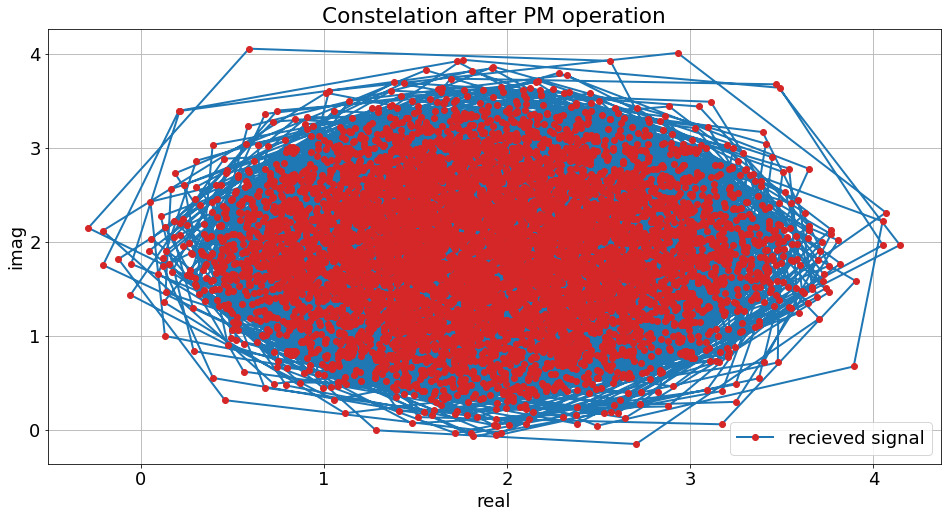

In [6]:
plt.figure(figsize=(16, 8))
plt.plot(sfm[0, :10000].real, sfm[0, :10000].imag, linestyle='-', marker='o',
         markerfacecolor='tab:red',
         markeredgecolor='tab:red')
plt.legend(['recieved signal'], loc='lower right')
plt.xlabel('real')
plt.ylabel('imag')
plt.title('Constelation after PM operation')
plt.grid(True)

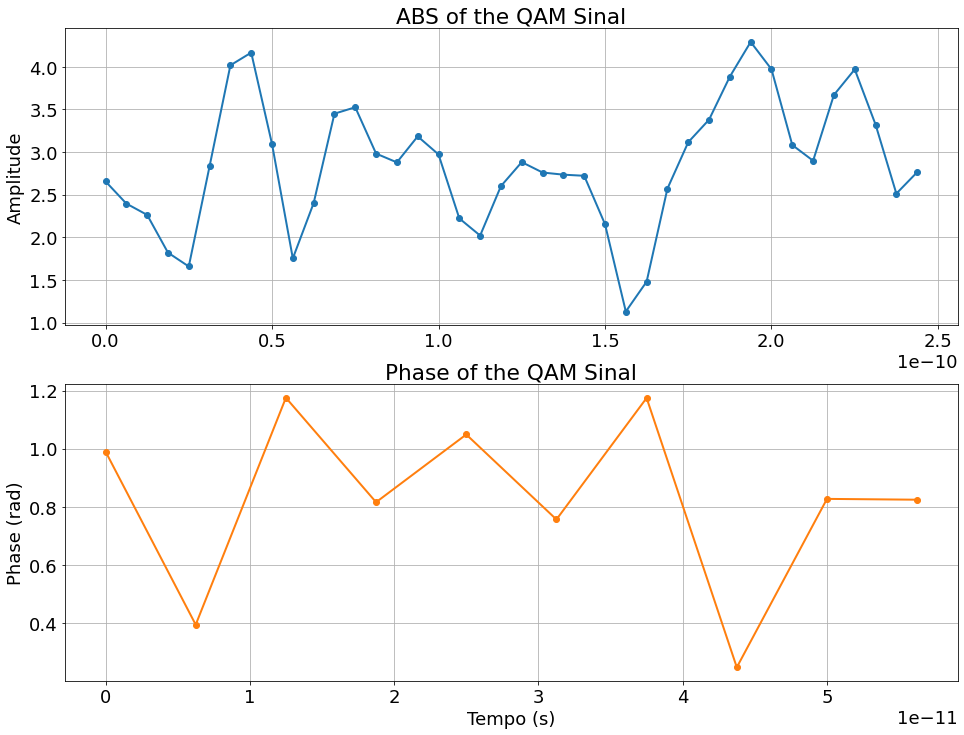

In [7]:
# valor absoluto do sinal -> entrada da rede
amplitudes_train = np.abs(sfm[0])
phases_train = np.angle(sfm[0, ::SpS])  # fase do sinal     -> saída desejada

# valor absoluto do sinal  -> entrada da rede
amplitudes_test = np.abs(sfm[1])
phases_test = np.angle(sfm[1, ::SpS])  # fase do sinal      -> saída desejada

L = 10
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

axes[0].set_title("ABS of the QAM Sinal")
axes[0].plot(t[0:int(4*L)], amplitudes_train[0:int(4*L)], '-o', color='C0')
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)

axes[1].plot(t[0:L], phases_train[0:L], '-o', color='C1')
axes[1].set_title("Phase of the QAM Sinal")
axes[1].set_xlabel("Tempo (s)")
axes[1].set_ylabel("Phase (rad)")
axes[1].grid(True)

In [8]:
X_train = amplitudes_train.reshape(-1, SpS)[:5000]
X_test = amplitudes_test.reshape(-1, SpS)[:5000]

In [9]:
y_train = phases_train.reshape(-1, 1)[:5000]

y_test = phases_test.reshape(-1, 1)[:5000]

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
num_features = SpS
length = 4
generator = TimeseriesGenerator(X_train, y_train, length=length, batch_size=1)

In [12]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, num_features)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               42000     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 52,201
Trainable params: 52,201
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [15]:
validation_generator = TimeseriesGenerator(
    X_test, y_test, length=length, batch_size=1)

In [16]:
model.fit_generator(generator, epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
4996/4996 [==============================] - 30s 5ms/step - loss: 0.0560 - val_loss: 0.0319
Epoch 2/20
4996/4996 [==============================] - 24s 5ms/step - loss: 0.0371 - val_loss: 0.0400
Epoch 3/20
4996/4996 [==============================] - 28s 6ms/step - loss: 0.0333 - val_loss: 0.0295
Epoch 4/20
4996/4996 [==============================] - 28s 6ms/step - loss: 0.0313 - val_loss: 0.0315
Epoch 5/20
4996/4996 [==============================] - 24s 5ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 6/20
4996/4996 [==============================] - 24s 5ms/step - loss: 0.0292 - val_loss: 0.0267
Epoch 7/20
4996/4996 [==============================] - 25s 5ms/step - loss: 0.0267 - val_loss: 0.0256
Epoch 8/20
4996/4996 [==============================] - 26s 5ms/step - loss: 0.0271 - val_loss: 0.0249
Epoch 9/20
4996/4996 [==============================] - 26s 5ms/step - loss: 0.0253 - val_loss: 0.0355
Epoch 10/20
4996/4996 [==============================] - 26s 5ms/step - l

In [23]:
preds = []

for x in range(len(y_test)-length):
    prediction = model.predict(validation_generator[x][0])[0][0]
    preds.append(prediction)

preds = np.array(preds).reshape((-1, 1))

In [18]:
model.evaluate_generator(validation_generator)

0.0258167814463377

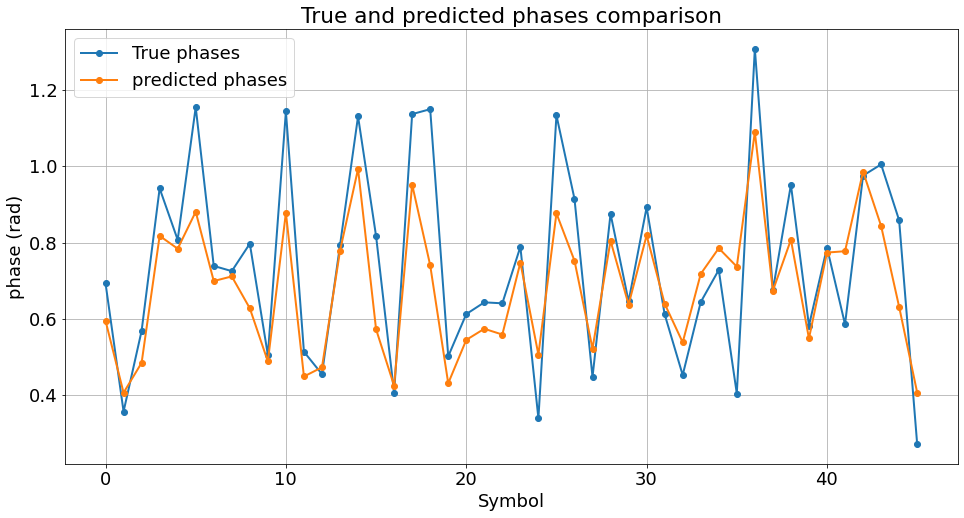

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[length:50], '-o')
plt.plot(preds[:50-length], '-o')
plt.xlabel('Symbol')
plt.ylabel('phase (rad)')
plt.legend(['True phases', 'predicted phases'])
plt.title('True and predicted phases comparison')
plt.grid(True)
plt.show()

In [26]:
print('RMSE = ',np.sqrt(mean_squared_error(y_test[length:],preds)))
print('R2 score = ',r2_score(y_test[length:],preds))

RMSE =  0.16067612635830278
R2 score =  0.6230667157690642
